**Setup**

In [1]:
import numpy as np
import webbrowser
from scipy.io import loadmat
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from time import sleep

In [2]:
import mne
data_path = mne.datasets.sample.data_path()
subjects_dir = data_path + '/subjects'
sample_dir = data_path + '/MEG/sample'
surf_dir = subjects_dir + '/sample/surf'


** Setting up nilearn **

In [3]:
import pandas as pd
import nibabel as nb

# Load target information as string and give a numerical identifier to each
from nilearn import datasets
haxby_dataset = datasets.fetch_haxby()

fmri_filename = haxby_dataset.func[0]
mask_filename = haxby_dataset.mask_vt[0]
mask_brain_filename = haxby_dataset.mask
fmri_data = nb.load(fmri_filename)
fmri_data.get_data()
labels = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')

**Setting up 3d brain viz**

In [4]:
# More brain stuff
import nibabel as nb

# Read in raw data
stc = mne.read_source_estimate(data_path + '/MEG/sample/sample_audvis-meg-eeg')
stc.crop(0.09, 0.09)
stc = stc.morph('sample', grade=None, smooth=10, subjects_dir=subjects_dir,
                subject_from='sample')

# Pull the vertices information for each hemisphere
# azimuths = dict(lh=dict(lat=270, med=90), rh=dict(lat=90, med=270))
hemis = ['lh']  # We'll plot these hemispheres
hemi_data = dict(lh=stc.data[:len(stc.vertices[0]), 0],
                 rh=stc.data[len(stc.vertices[0]):, 0])

rr_all, tris_all, curv_all = [], [], []
for hi, hemi in enumerate(hemis):
    data = hemi_data[hemi]
    data /= 23
    surf = surf_dir + '/%s.pial' % hemi
    curv = surf_dir + '/%s.curv' % hemi
    rr, tris = nb.freesurfer.read_geometry(surf)
    rr -= rr.mean()
    tris = tris.astype(np.uint32)
    
    assert len(data) == len(rr)
    
    # Correct curvature
    curv = nb.freesurfer.read_morph_data(curv)
    curv = (curv > 0).astype(float)
    curv = (curv - 0.5) / 3 + 0.5
    curv = curv[:, np.newaxis] * [1, 1, 1]
    rr_all.append(rr)
    tris_all.append(tris)
    curv_all.append(curv)
    
# Collect outputs
rr = np.vstack(rr_all)
tris = np.vstack(tris_all)
curv = np.vstack(curv_all)


Morphing data...
    Left-hemisphere map read.
    Right-hemisphere map read.
    Left-hemisphere map read.
    Right-hemisphere map read.
    10 smooth iterations done.
    10 smooth iterations done.
[done]


---


# Brain visualization with python

## Visualizing noisy EEG data with MNE-python

<img src="./extras/mne_logo.png" style="width:30%") />


In [5]:
import mne

## Read in raw data

This data was collected from people who either listened to pure tones or viewed images.

In [6]:
# Read in some raw data
raw = mne.io.read_raw_fif(sample_dir + '/sample_audvis_raw.fif',
                          preload=True)
raw.pick_types(meg=False, eeg=True)

Opening raw data file /Users/choldgraf/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 59 x 166800 (277.7 sec), ~78.2 MB, data loaded>

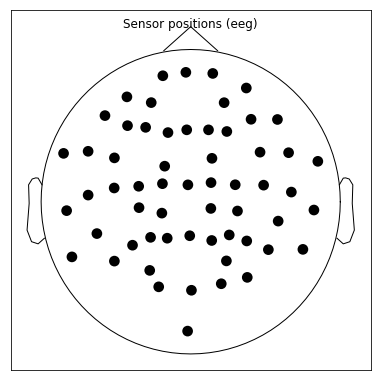

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
raw.plot_sensors(axes=ax);
# raw.info

## We can plot the raw data...

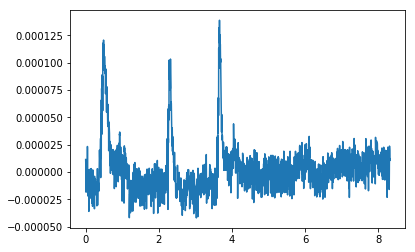

In [8]:
# Extract the timecourse
data_eeg, times = raw[:10, :5000]

# Plot the data
fig, ax = plt.subplots()
ax.plot(times, data_eeg[0])

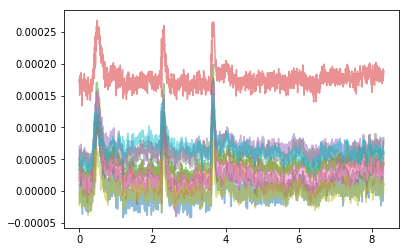

In [9]:
# We can even plot lots of raw data!
fig, ax = plt.subplots()
ax.plot(times, data_eeg[:10].T, alpha=.5);

## ...but MNE handles this much better

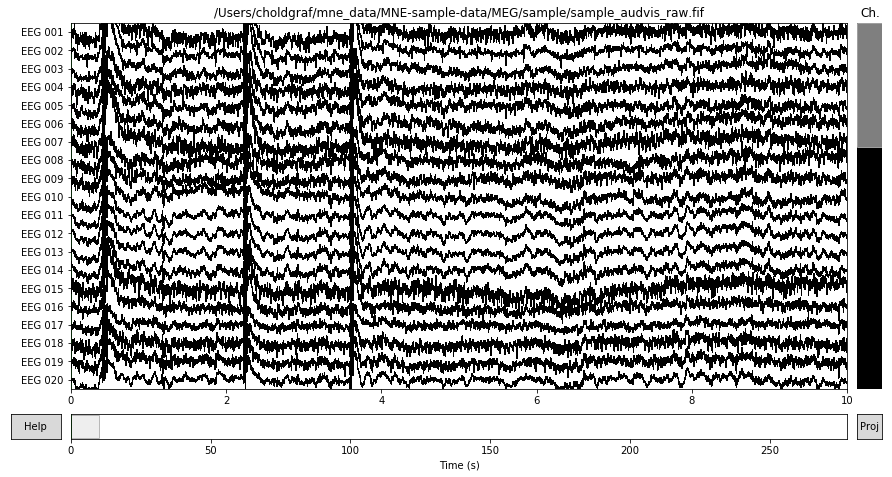

In [10]:
raw.plot();

## Let's add some information about the world

## ...via events

In [11]:
# Read in event timings
event_id = {'auditory': 1, 'visual': 3}
events = mne.read_events(sample_dir + '/sample_audvis_raw-eve.fif',
                         include=list(event_id.values()))
print(events[:5])

[[28345     0     3]
 [28771     0     1]
 [30025     0     3]
 [30450     0     1]
 [31665     0     3]]


We can show where these events happened in time

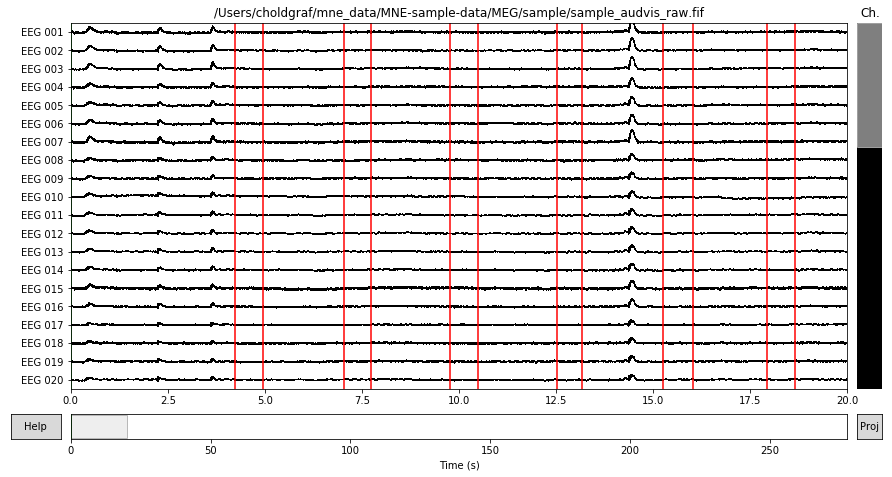

In [12]:
raw.plot(events=events, event_color='red', duration=20, scalings='auto');

## Digging in to the event structure
We can use these events to slice up our raw data and grab a window around each event.

In [13]:
# Create epochs
epochs = mne.Epochs(raw, events, event_id)

print('\n---\n\n', epochs.get_data().shape)

145 matching events found
3 projection items activated
Loading data for 145 events and 421 original time points ...
0 bad epochs dropped

---

 (145, 59, 421)


Loading data for 145 events and 421 original time points ...
Loading data for 5 events and 421 original time points ...


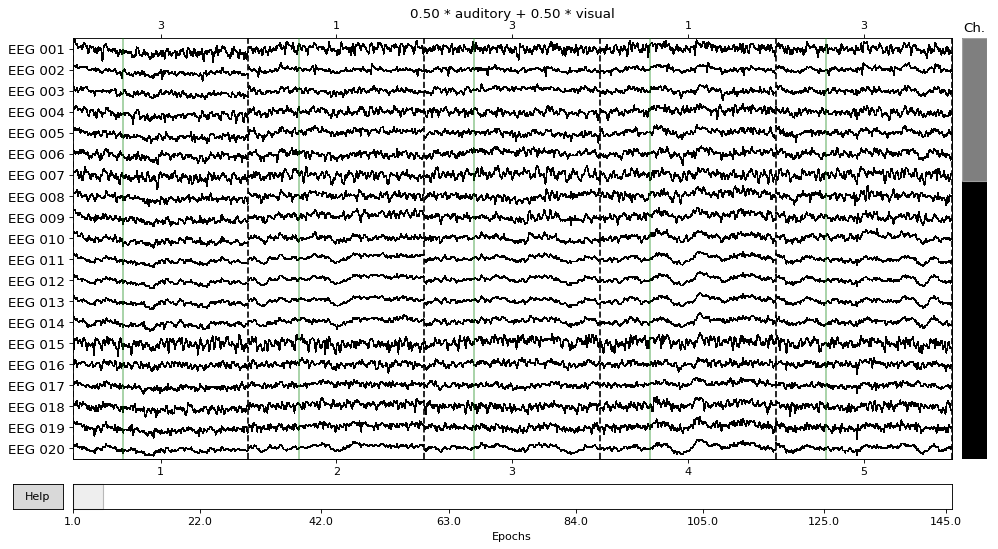

In [14]:
epochs.plot(n_epochs=5, scalings='auto');

## Let's remove some of that noise
All neural data is noisy. Especially EEG data. We can remove some noise by averaging across trials.

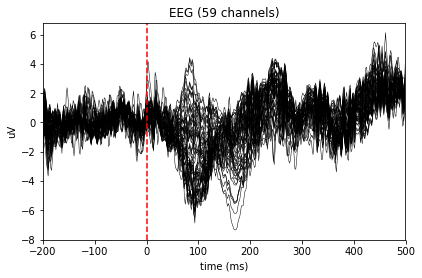

In [15]:
average = epochs.average()
fig = average.plot(show=False);
# try `gfp=True`

fig.axes[0].axvline(0, ls='--', c='r')

### Let's add some more information to this plot

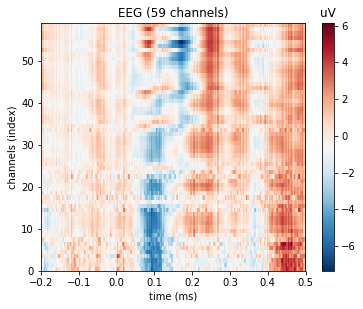

In [16]:
# Visualizing channel activity as an image
average.plot_image();

Now we pack in information about both space and time:

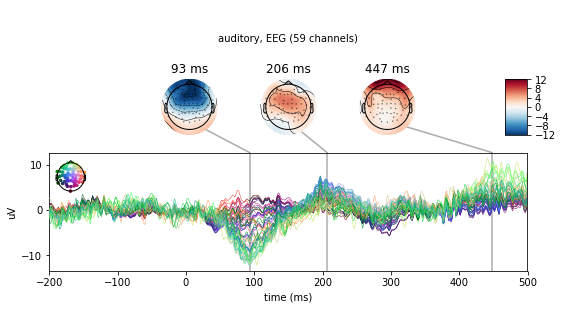

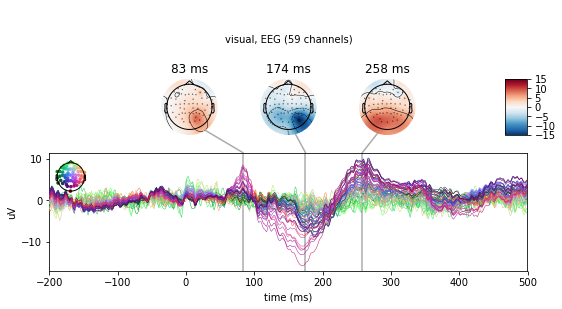

In [17]:
# Plot the mean response for each subset
for kind in event_id.keys():
    # Take the subset and calculate the average
    subset = epochs[kind]
    av = subset.average()
    
    # Only take a subset of electrodes
    ixs_plot = mne.pick_types(av.info, meg=False, eeg=True)

    # Make the plot
    _ = av.plot_joint(picks=ixs_plot, title=kind)

## Takeaway: Flexibility in visualization is crucial.

* Need to have multiple views on the same data.
* Keep in mind the trifecta!

# Integrating with machine learning and statistical workflows

As we ask more complex questions about the brain, it's becoming important to combine traditional neural data with modern statistical paradigms.

`nilearn` aims to allow neuroscientists to incorporate machine learning into their work.

<center>
<img src="extras/nilearn_logo.png" style="height: 200px; float: left"/>
<img src="extras/sklearn_logo.png" style="height: 200px"/>
</center>

In [18]:
import nilearn as ni

## The task

<center><img src="extras/cat.jpg" style="width:30%"/>

<span style="font-size:2em">vs</span>

<img src="extras/einstein.jpg" style="width: 30%"/>
</center>

## Retrieve and loading the fMRI data

The `nilearn.datasets.fetch_haxby` function pulls the data from an online repository.

In [19]:
from nilearn import datasets
from nilearn import plotting

# By default the 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
fmri_filename = haxby_dataset.func[0]
mask_filename = haxby_dataset.mask_vt[0]

fMRI data has dimensions `(x, y, z, time)`

In [20]:
fmri = nb.load(fmri_filename)
fmri.shape

(40, 64, 64, 1452)

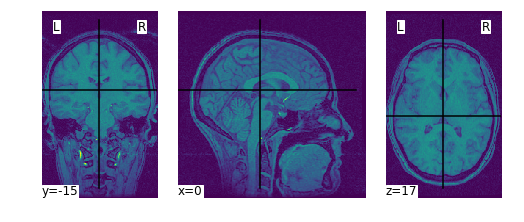

In [21]:
plotting.plot_img(haxby_dataset.anat[0])

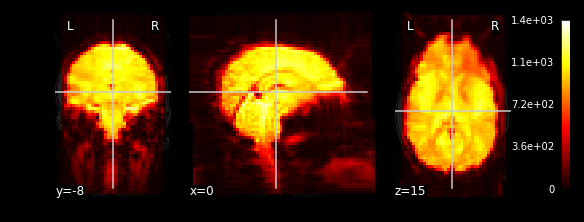

In [22]:
from nilearn.image import iter_img
for ii, img in enumerate(iter_img(fmri_data)):
    if ii > 0:
        continue

    # img is now an in-memory 3D img
    plotting.plot_stat_map(img, threshold=3, display_mode="ortho", bg_img=haxby_dataset.anat[0])

## Visualizing in space: Preparing the fMRI volume for model fitting

Effectively, we wish to do two things:

1. Extract a subset of voxels from the nifty file (masking)
2. Reshape these voxels so that they can be used to fit a model (vectorizing)

`nilearn` allows us to do this easily, turning the 4-D matrix of into an array of shape (n_samples, n_features). This allows us to use scikit-learn to do machine learning.

Let's see what these masks look like.

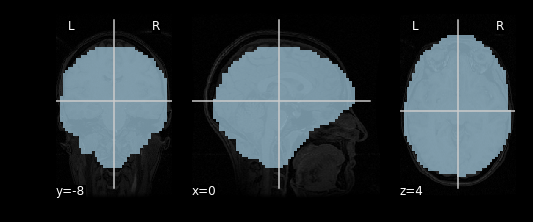

In [23]:
# Show us a mask for the whole brain
plotting.plot_roi(mask_brain_filename, bg_img=haxby_dataset.anat[0],
                  cmap='Paired')

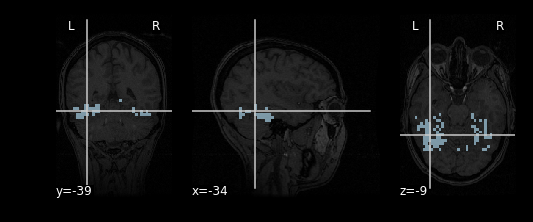

In [24]:
# Show us a mask for a subset of the brain
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                  cmap='Paired')

Notice that only a few of the voxels are being shown here. These are the voxels that the mask has extracted.

## Now for some machine learning!

We'll use the `NiftiMasker` class to reshape this volume data into a scikit-learn shape.

In [25]:
from nilearn.input_data import NiftiMasker

# masker = NiftiMasker(mask_img=mask_filename, standardize=True)  # For a subset of the brain
masker = NiftiMasker(mask_img=mask_brain_filename, standardize=True)  # For the whole brain

# Maskers act kind of like scikit-learn transformers
fmri_masked = masker.fit_transform(fmri_data)
print(fmri_masked.shape)

(1452, 39912)



Now we have all the components we'll need to fit a model.

As our data is already in the shape for `sklearn`, it's quite easy to fit the model.

In [26]:
# Create a mask for only the categories we care about
condition_mask = labels.eval('labels in ["face", "cat"]').values

# Create our X / y variables
X = fmri_masked[condition_mask]
targets = labels[condition_mask]['labels'].values

print(X.shape, targets.shape)

(216, 39912) (216,)


In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(X, targets)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Projecting back into the brain
Using our `NiftiMasker`, we can collect model coefficients and reshape them back into the 3-D space of our fMRI data.

We need to turn it back into a Nifti image, in essence, "inverting"
what the NiftiMasker has done.

For this, we can call inverse_transform on the NiftiMasker:

In [28]:
coef_img = masker.inverse_transform(svc.coef_)
print(type(coef_img))

<class 'nibabel.nifti1.Nifti1Image'>


coef_img is now a NiftiImage. This means that we can plot it on the brain. 

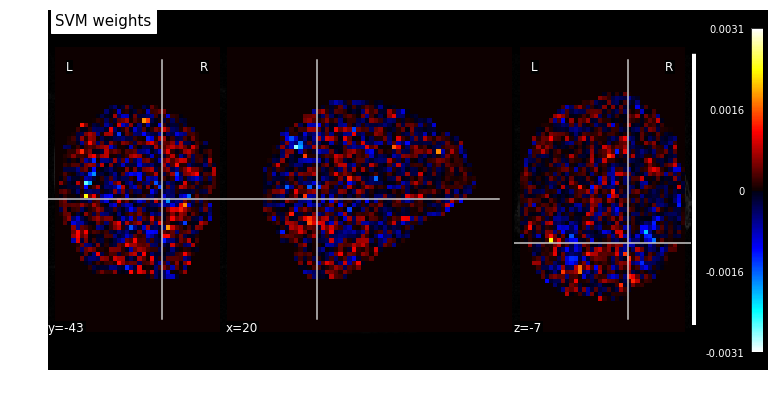

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
plotting.plot_stat_map(coef_img, bg_img=haxby_dataset.anat[0],
                       title="SVM weights", threshold=None, figure=fig)

# Can play around with the threshold=N as well

## Takeaway: Design the API w/ other tools in mind.

# Interactive and 3D plotting

The next wave of visualizing the brain is interactive computing.

<center><img src="extras/jupyter.png" /></center>

* [pythreejs](https://github.com/jovyan/pythreejs)
* [pycortex](https://github.com/gallantlab/pycortex)

In [30]:
# 3D viz plotting
from pythreejs import (PlainBufferGeometry, Mesh, PerspectiveCamera, Scene, TrackballControls,
                       AmbientLight, Renderer, PhongMaterial, DirectionalLight, OrbitControls, SphereGeometry,
                       LambertMaterial, LineBasicMaterial, PlainGeometry, Line)

pythreejs gives us a few simple geometries that we can use to build javascript visualizations

In [31]:
# Pull values from our data
vertices = rr
faces = tris
vertexcolors = curv

# Define a surface object
geom = PlainBufferGeometry(vertices=vertices, faces=faces, colors=vertexcolors)
mesh = Mesh(geometry=geom, material=PhongMaterial(shininess=0,vertexColors='VertexColors'))

# Now create our camera + objects
camera = PerspectiveCamera(position=[500, 500, 500], fov=20,
                           children=[DirectionalLight(color='#ffffff',
                                                      position=[-3, 5, 1],
                                                      intensity=0.5)])
plot_objects = [mesh, AmbientLight(color='#dddddd')]

# Finally create the scene
scene = Scene(children=plot_objects)

renderer = Renderer(camera=camera, background='black', background_opacity=1,
                    scene=scene, controls=[OrbitControls(controlling=camera)])

In [32]:
camera.position = [-433.8605682143605, -27.056496775163907, 93.12907269086038]
mesh.position = list(- rr.mean(0))
camera.up = [1, 0, 0]

In [33]:
renderer

A Jupyter Widget

Some unnecessarily complex code to try and make a pretty picture!

In [34]:
# Define some random spots of activity
all_colors = []

# Generate random focii of activity
ixs_activity = np.random.choice(np.arange(geom.vertices.shape[0]), 40)

# Pre-create activity patterns at these foci
for var in tqdm(np.hstack([np.linspace(10, 300, 3), np.linspace(200, 10, 2)])):
    active_spots = geom.vertices[ixs_activity]
    this_distances = []
    for i_elec in active_spots:
        rnd = multivariate_normal(i_elec, var)
        distance = rnd.pdf(rr)
        this_distances.append(distance)
    this_distances = np.array(this_distances)

    # Update colors with this activity
    # cmap = plt.cm.viridis
    cmap = plt.cm.magma
    norm_distances = MinMaxScaler().fit_transform(this_distances.sum(0)[:, np.newaxis])
    colors = cmap(norm_distances).squeeze()[:, :3]
    all_colors.append(colors)
all_colors = np.array(all_colors)

100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


We can easily update properties of the figure by modifying attributes of our pythreejs objects.

In [35]:
renderer

A Jupyter Widget

In [36]:
geom.colors = all_colors[1]
# for color in all_colors:
#     geom.colors = color

## Exploration after publication

Finally, [pycortex](https://github.com/gallantlab/pycortex) is a recent project for more feature-filled visualizations of the human brain.

Using it, the [Gallant Lab](gallantlab.org) has been able to paint a more rich picture of their results.

In [37]:
!open extras/brainleft_movie_stim.mp4  # This won't work on your computer! 

Check out their recent visualization here:

gallantlab.org/huth2016

<a href="http://gallantlab.org/huth2016/"> <img src="extras/3dhead.png" style="width:30%"/></a>

# What have we learned?

* Neuroscience has come a long way from drawing individual neurons.

* Embrace the messiness by enabling multiple views on the same data.

* Develop visualizations with analysis + tools in mind.

* Interactive visualizations can open up new questions after initial findings

# Thanks!

[github.com/choldgraf/talk-plotcon_2017](http://github.com/choldgraf/talk-plotcon_2017)

## OSS
* [MNE-python](https://www.martinos.org/mne/stable/_images/mne_logo.png)
* [nilearn](http://nilearn.github.io/)
* [pythreejs](https://github.com/jovyan/pythreejs)
* [pycortex](https://gallantlab.github.io/index.html)

## Me!
* @choldgraf
* github.com/choldgraf

## Institutes
* [Berkeley Institute for Data Science](https://bids.berkeley.edu/)
* [Helen Wills Neuroscience Institute](http://neuroscience.berkeley.edu/)
